In [ ]:
#!pip install transformers 

# Data Processing
import pandas as pd
import numpy as np
import pickle
import joblib

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_xtrain_embedding.pickle', 'rb') as pkl:
    x_train_ami = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_ytrain_embedding.pickle', 'rb') as pkl:
    y_train_ami = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_xval_embedding.pickle', 'rb') as pkl:
    x_val_ami = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_yval_embedding.pickle', 'rb') as pkl:
    y_val_ami = pickle.load(pkl)  

In [ ]:
with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_xtrain_embedding.pickle', 'rb') as pkl:
    x_train_reddit = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_ytrain_embedding.pickle', 'rb') as pkl:
    y_train_reddit = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_xval_embedding.pickle', 'rb') as pkl:
    x_val_reddit = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_yval_embedding.pickle', 'rb') as pkl: 
    y_val_reddit = pickle.load(pkl)

In [ ]:
x_train_reddit = x_train_reddit.reshape(-1,x_train_reddit.shape[-1])
x_val_reddit=x_val_reddit.reshape(-1,x_val_reddit.shape[-1])

In [ ]:
#name='GaussianNB'
#estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
#print(estimator.best_estimator_)
from sklearn.naive_bayes import MultinomialNB
model = GaussianNB()
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
x_train_ami = scaler.fit_transform(x_train_ami)
x_val_reddit = scaler.transform(x_val_reddit.cpu())
x_train_reddit = scaler.fit_transform(x_train_reddit.cpu())
#model.fit(x_train_reddit.cpu(),y_train_reddit)
model.fit(x_train_ami,y_train_ami)
model.fit(x_train_reddit,y_train_reddit)
preds = model.predict(x_val_reddit)

NameError: ignored

In [ ]:
preds = model.predict(x_val_reddit)
accuracy = accuracy_score(y_val_reddit, preds)
precision = precision_score(y_val_reddit, preds)
recall = recall_score(y_val_reddit, preds)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5395849346656418
Precision: 0.15942028985507245
Recall: 0.8527131782945736


Classification Report:


              precision    recall  f1-score   support

           0       0.97      0.51      0.66      1172
           1       0.16      0.85      0.27       129

    accuracy                           0.54      1301
   macro avg       0.56      0.68      0.47      1301
weighted avg       0.89      0.54      0.62      1301



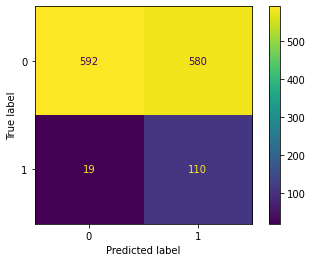

In [ ]:
cm = confusion_matrix(y_val_reddit, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
print('Classification Report:')
print('\n')
print(classification_report(y_val_reddit, preds))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def calculate_weights(labels): 
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), 
                y=labels)
  return class_weights

In [ ]:
#cw=calculate_weights(y_val_reddit)
cw=dict(zip(np.unique(y_train_reddit), compute_class_weight(class_weight='balanced', classes=np.unique(y_train_reddit), 
                y=y_train_reddit.to_list())))

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
processed_data = {}
def construct_model_ami(x_train,y_train):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        DecisionTreeClassifier(random_state=0),
        SVC(random_state=0), 
        
    ]
    
    logregress_parameters = { 
        'C'       : np.logspace(-1,1,3),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    }
    
    svc_parameters ={   
        'C': [0.1, 1, 10], 
        'gamma': [1, 0.1, 0.01],
        'kernel': ['linear']
    } 
    dt_parameters = {
        'criterion':['gini','entropy'],
        'max_depth':[4,6,10]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        dt_parameters,
        svc_parameters, 
        
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        #X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(x_train,y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [ ]:
construct_model_ami(x_train_ami,y_train_ami)

In [ ]:
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")
    joblib.dump(clf.best_estimator_, '/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))

LogisticRegression
Tuned Hyperparameters : {'C': 1.0, 'solver': 'liblinear'}
Accuracy : 0.758822307023841
__________________________________________________________
DecisionTreeClassifier
Tuned Hyperparameters : {'criterion': 'entropy', 'max_depth': 6}
Accuracy : 0.6667711993551719
__________________________________________________________
SVC
Tuned Hyperparameters : {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy : 0.7565622599211597
__________________________________________________________


In [ ]:
def best_model(name):
  estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
  print(estimator)
  estimator.fit(x_train_ami,y_train_ami)
  preds = estimator.predict(x_val_reddit.cpu().detach().numpy())
  accuracy = accuracy_score(y_val_reddit, preds)
  precision = precision_score(y_val_reddit, preds)
  recall = recall_score(y_val_reddit, preds)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  # Create the confusion matrix
  cm = confusion_matrix(y_val_reddit, preds)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  print('Classification Report:')
  print('\n')
  print(classification_report(y_val_reddit, preds))

SVC(C=0.1, gamma=1, kernel='linear', random_state=0)
Accuracy: 0.676402767102229
Precision: 0.18803418803418803
Recall: 0.6821705426356589
Classification Report:


              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1172
           1       0.19      0.68      0.29       129

    accuracy                           0.68      1301
   macro avg       0.57      0.68      0.54      1301
weighted avg       0.88      0.68      0.74      1301



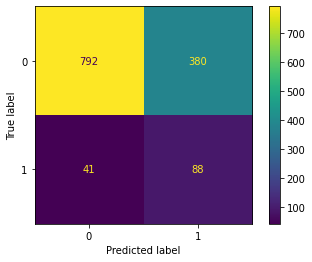

In [ ]:
best_model('SVC')

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.7471176018447349
Precision: 0.1875
Recall: 0.46511627906976744
Classification Report:


              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1172
           1       0.19      0.47      0.27       129

    accuracy                           0.75      1301
   macro avg       0.56      0.62      0.56      1301
weighted avg       0.86      0.75      0.79      1301



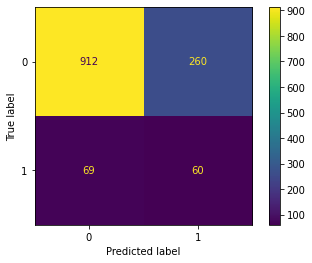

In [ ]:
best_model('LogisticRegression')

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)
Accuracy: 0.6241352805534205
Precision: 0.12343096234309624
Recall: 0.4573643410852713
Classification Report:


              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1172
           1       0.12      0.46      0.19       129

    accuracy                           0.62      1301
   macro avg       0.52      0.55      0.47      1301
weighted avg       0.84      0.62      0.70      1301



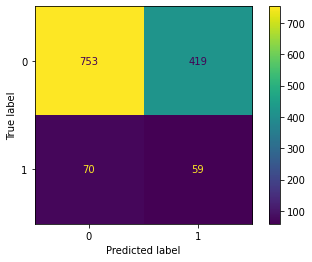

In [ ]:
best_model('DecisionTreeClassifier')

In [ ]:
def best_model_ami_reddit(name):
  estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
  print(estimator)
  estimator.fit(x_train_reddit.cpu(),y_train_reddit)
  preds = estimator.predict(x_val_reddit.cpu().detach().numpy())
  accuracy = accuracy_score(y_val_reddit, preds)
  precision = precision_score(y_val_reddit, preds)
  recall = recall_score(y_val_reddit, preds)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  # Create the confusion matrix
  cm = confusion_matrix(y_val_reddit, preds)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  print('Classification Report:')
  print('\n')
  print(classification_report(y_val_reddit, preds))

SVC(C=0.1, gamma=1, kernel='linear', random_state=0)
Accuracy: 0.9116064565718678
Precision: 0.6521739130434783
Recall: 0.23255813953488372
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1172
           1       0.65      0.23      0.34       129

    accuracy                           0.91      1301
   macro avg       0.79      0.61      0.65      1301
weighted avg       0.89      0.91      0.89      1301



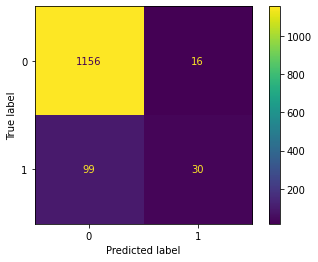

In [ ]:
best_model_ami_reddit('SVC')

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.8954650269023828
Precision: 0.4520547945205479
Recall: 0.2558139534883721
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1172
           1       0.45      0.26      0.33       129

    accuracy                           0.90      1301
   macro avg       0.69      0.61      0.64      1301
weighted avg       0.88      0.90      0.88      1301



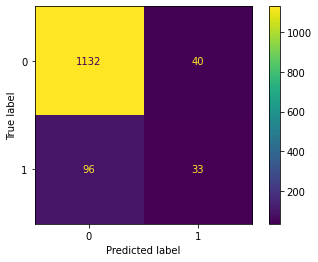

In [ ]:
best_model_ami_reddit('LogisticRegression')

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)
Accuracy: 0.8862413528055342
Precision: 0.2682926829268293
Recall: 0.08527131782945736
Classification Report:


              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1172
           1       0.27      0.09      0.13       129

    accuracy                           0.89      1301
   macro avg       0.59      0.53      0.53      1301
weighted avg       0.84      0.89      0.86      1301



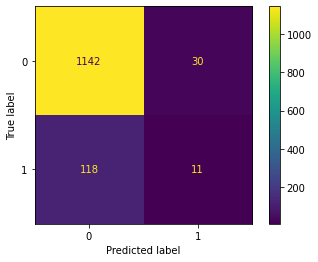

In [ ]:
best_model_ami_reddit('DecisionTreeClassifier')

In [ ]:
processed_data = {}
def construct_model_reddit(x_train,y_train):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        DecisionTreeClassifier(random_state=0),
        SVC(random_state=0), 
    ]
    
    logregress_parameters = { 
        'C'       : np.logspace(-1,1,3),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    }
    
    svc_parameters ={   
        'C': [0.1, 1, 10], 
        'gamma': [1, 0.1, 0.01],
        'kernel': ['linear']
    } 
    dt_parameters = {
        #'criterion':['gini','entropy'],
        'max_depth':[200,300,500]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        dt_parameters,
        svc_parameters, 
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        #X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(x_train,y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [ ]:
construct_model_reddit(x_train_reddit.cpu(),y_train_reddit)

In [ ]:
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")
    joblib.dump(clf.best_estimator_, '/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))

LogisticRegression
Tuned Hyperparameters : {'C': 0.1, 'solver': 'liblinear'}
Accuracy : 0.902365381133442
__________________________________________________________
DecisionTreeClassifier
Tuned Hyperparameters : {'max_depth': 200}
Accuracy : 0.8294644215100488
__________________________________________________________
SVC
Tuned Hyperparameters : {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy : 0.9044569980083288
__________________________________________________________


In [ ]:
def best_model_reddit(name):
  estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))
  print(estimator)
  estimator.fit(x_train_reddit.cpu(),y_train_reddit)
  preds = estimator.predict(x_val_reddit.cpu())
  accuracy = accuracy_score(y_val_reddit, preds)
  precision = precision_score(y_val_reddit, preds)
  recall = recall_score(y_val_reddit, preds)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  # Create the confusion matrix
  cm = confusion_matrix(y_val_reddit, preds)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  print('Classification Report:')
  print('\n')
  print(classification_report(y_val_reddit, preds))

SVC(C=0.1, gamma=1, kernel='linear', random_state=0)
Accuracy: 0.9116064565718678
Precision: 0.6521739130434783
Recall: 0.23255813953488372
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1172
           1       0.65      0.23      0.34       129

    accuracy                           0.91      1301
   macro avg       0.79      0.61      0.65      1301
weighted avg       0.89      0.91      0.89      1301



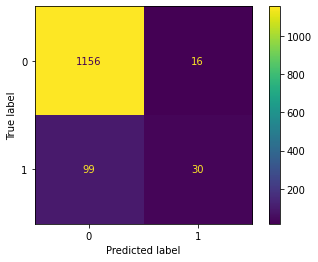

In [ ]:
best_model_reddit('SVC')

LogisticRegression(C=0.1, random_state=0, solver='liblinear')
Accuracy: 0.9093005380476556
Precision: 0.6078431372549019
Recall: 0.24031007751937986
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1172
           1       0.61      0.24      0.34       129

    accuracy                           0.91      1301
   macro avg       0.76      0.61      0.65      1301
weighted avg       0.89      0.91      0.89      1301



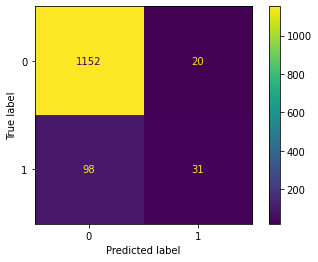

In [ ]:
best_model_reddit('LogisticRegression')

DecisionTreeClassifier(max_depth=200, random_state=0)
Accuracy: 0.8447348193697156
Precision: 0.22962962962962963
Recall: 0.24031007751937986
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1172
           1       0.23      0.24      0.23       129

    accuracy                           0.84      1301
   macro avg       0.57      0.58      0.57      1301
weighted avg       0.85      0.84      0.85      1301



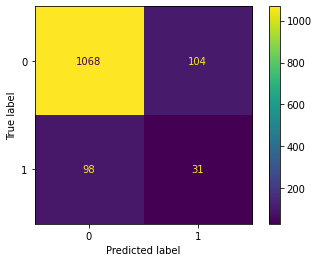

In [ ]:
best_model_reddit('DecisionTreeClassifier')

### Combining all 6 models

In [ ]:
name='SVC'
ami_sv = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
ami_sv = SVC(C=0.1, gamma=1, kernel='linear', random_state=0,probability=True)
ami_sv.fit(x_train_ami,y_train_ami)
preds_ami_sv  = ami_sv.predict(x_val_reddit.cpu())
preds_proba_ami_sv = ami_sv.predict_proba(x_val_reddit.cpu())
preds_proba_ami_sv


name='LogisticRegression'
ami_lr = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
ami_lr.fit(x_train_ami,y_train_ami)
preds_ami_lr  = ami_lr.predict(x_val_reddit.cpu())
preds_proba_ami_lr = ami_lr.predict_proba(x_val_reddit.cpu())
preds_proba_ami_lr

name='DecisionTreeClassifier'
ami_dt = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
ami_dt.fit(x_train_ami,y_train_ami)
preds_ami_dt = ami_dt.predict(x_val_reddit.cpu())
preds_proba_ami_dt = ami_dt.predict_proba(x_val_reddit.cpu())
preds_proba_ami_dt

array([[0.45      , 0.55      ],
       [0.68421053, 0.31578947],
       [0.716     , 0.284     ],
       ...,
       [0.4       , 0.6       ],
       [0.29577465, 0.70422535],
       [0.29577465, 0.70422535]])

In [ ]:
df_probas = pd.DataFrame(columns = ['AMI_SVC_0','AMI_LR_0','AMI_DT_0','RED_SVC_0','RED_LR_0','RED_DT_0',
                                    'AMI_SVC_1','AMI_LR_1','AMI_DT_1','RED_SVC_1','RED_LR_1','RED_DT_1'])


In [ ]:
df_probas['AMI_SVC_0']=preds_proba_ami_sv[:,0]
df_probas['AMI_SVC_1']=preds_proba_ami_sv[:,1]

df_probas['AMI_LR_0']=preds_proba_ami_lr[:,0]
df_probas['AMI_LR_1']=preds_proba_ami_lr[:,1]

df_probas['AMI_DT_0']=preds_proba_ami_dt[:,0]
df_probas['AMI_DT_1']=preds_proba_ami_dt[:,1]

In [ ]:
df_probas

,AMI_SVC_0,AMI_LR_0,AMI_DT_0,RED_SVC_0,RED_LR_0,RED_DT_0,AMI_SVC_1,AMI_LR_1,AMI_DT_1,RED_SVC_1,RED_LR_1,RED_DT_1
0,0.153736,0.511808,0.450000,NaN,NaN,NaN,0.846264,0.488192,0.550000,NaN,NaN,NaN
1,0.974909,0.998017,0.684211,NaN,NaN,NaN,0.025091,0.001983,0.315789,NaN,NaN,NaN
2,0.711504,0.972237,0.716000,NaN,NaN,NaN,0.288496,0.027763,0.284000,NaN,NaN,NaN
3,0.967432,0.980073,0.673913,NaN,NaN,NaN,0.032568,0.019927,0.326087,NaN,NaN,NaN
4,0.977398,0.999171,1.000000,NaN,NaN,NaN,0.022602,0.000829,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1296,0.261979,0.186734,0.777778,NaN,NaN,NaN,0.738021,0.813266,0.222222,NaN,NaN,NaN
1297,0.072792,0.067695,0.400000,NaN,NaN,NaN,0.927208,0.932305,0.600000,NaN,NaN,NaN
1298,0.072792,0.067695,0.400000,NaN,NaN,NaN,0.927208,0.932305,0.600000,NaN,NaN,NaN
1299,0.864366,0.859017,0.295775,NaN,NaN,NaN,0.135634,0.140983,0.704225,NaN,NaN,NaN


In [ ]:
name='SVC'
red_sv = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))
red_sv = SVC(C=0.1, gamma=1, kernel='linear', random_state=0,probability=True)
red_sv.fit(x_train_reddit.cpu(),y_train_reddit)
preds_red_sv  = red_sv.predict(x_val_reddit.cpu())
preds_proba_red_sv = red_sv.predict_proba(x_val_reddit.cpu())
preds_proba_red_sv


name='LogisticRegression'
red_lr = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))
red_lr.fit(x_train_reddit.cpu(),y_train_reddit)
preds_red_lr  = red_lr.predict(x_val_reddit.cpu())
preds_proba_red_lr = red_lr.predict_proba(x_val_reddit.cpu())
preds_proba_red_lr

name='DecisionTreeClassifier'
red_dt = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))
red_dt.fit(x_train_reddit.cpu(),y_train_reddit)
preds_red_dt = red_dt.predict(x_val_reddit.cpu())
preds_proba_red_dt = red_dt.predict_proba(x_val_reddit.cpu())
preds_proba_red_dt

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
df_probas['RED_SVC_0']=preds_proba_red_sv[:,0]
df_probas['RED_SVC_1']=preds_proba_red_sv[:,1]

df_probas['RED_LR_0']=preds_proba_red_lr[:,0]
df_probas['RED_LR_1']=preds_proba_red_lr[:,1]

df_probas['RED_DT_0']=preds_proba_red_dt[:,0]
df_probas['RED_DT_1']=preds_proba_red_dt[:,1]

In [ ]:
df_probas

,AMI_SVC_0,AMI_LR_0,AMI_DT_0,RED_SVC_0,RED_LR_0,RED_DT_0,AMI_SVC_1,AMI_LR_1,AMI_DT_1,RED_SVC_1,RED_LR_1,RED_DT_1
0,0.153736,0.511808,0.450000,0.808942,0.903025,1.0,0.846264,0.488192,0.550000,0.191058,0.096975,0.0
1,0.974909,0.998017,0.684211,0.995420,0.997363,1.0,0.025091,0.001983,0.315789,0.004580,0.002637,0.0
2,0.711504,0.972237,0.716000,0.972443,0.984004,1.0,0.288496,0.027763,0.284000,0.027557,0.015996,0.0
3,0.967432,0.980073,0.673913,0.988965,0.994621,1.0,0.032568,0.019927,0.326087,0.011035,0.005379,0.0
4,0.977398,0.999171,1.000000,0.922063,0.940031,1.0,0.022602,0.000829,0.000000,0.077937,0.059969,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1296,0.261979,0.186734,0.777778,0.956278,0.946524,1.0,0.738021,0.813266,0.222222,0.043722,0.053476,0.0
1297,0.072792,0.067695,0.400000,0.759448,0.665794,1.0,0.927208,0.932305,0.600000,0.240552,0.334206,0.0
1298,0.072792,0.067695,0.400000,0.759448,0.665794,1.0,0.927208,0.932305,0.600000,0.240552,0.334206,0.0
1299,0.864366,0.859017,0.295775,0.931520,0.902826,1.0,0.135634,0.140983,0.704225,0.068480,0.097174,0.0


In [ ]:
df_probas['class0_total_probas'] = df_probas.iloc[:,0:6].sum(axis = 1)/6
df_probas['class1_total_probas'] = df_probas.iloc[:,6:12].sum(axis = 1)/6

In [ ]:
df_probas['True_label']=y_val_reddit

In [ ]:
pred_labels=[]
for i,j in df_probas.iterrows():
  if j['class0_total_probas']>j['class1_total_probas']:
    pred_labels.append(0)
  else:
    pred_labels.append(1)

In [ ]:
df_probas['predicted_label']=pred_labels

In [ ]:
df_probas

,AMI_SVC_0,AMI_LR_0,AMI_DT_0,RED_SVC_0,RED_LR_0,RED_DT_0,AMI_SVC_1,AMI_LR_1,AMI_DT_1,RED_SVC_1,RED_LR_1,RED_DT_1,class0_total_probas,class1_total_probas,True_label,predicted_label
0,0.153736,0.511808,0.450000,0.808942,0.903025,1.0,0.846264,0.488192,0.550000,0.191058,0.096975,0.0,0.637918,0.362082,0,0
1,0.974909,0.998017,0.684211,0.995420,0.997363,1.0,0.025091,0.001983,0.315789,0.004580,0.002637,0.0,0.941653,0.058347,0,0
2,0.711504,0.972237,0.716000,0.972443,0.984004,1.0,0.288496,0.027763,0.284000,0.027557,0.015996,0.0,0.892698,0.107302,0,0
3,0.967432,0.980073,0.673913,0.988965,0.994621,1.0,0.032568,0.019927,0.326087,0.011035,0.005379,0.0,0.934167,0.065833,0,0
4,0.977398,0.999171,1.000000,0.922063,0.940031,1.0,0.022602,0.000829,0.000000,0.077937,0.059969,0.0,0.973110,0.026890,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,0.261979,0.186734,0.777778,0.956278,0.946524,1.0,0.738021,0.813266,0.222222,0.043722,0.053476,0.0,0.688215,0.311785,0,0
1297,0.072792,0.067695,0.400000,0.759448,0.665794,1.0,0.927208,0.932305,0.600000,0.240552,0.334206,0.0,0.494288,0.505712,1,1
1298,0.072792,0.067695,0.400000,0.759448,0.665794,1.0,0.927208,0.932305,0.600000,0.240552,0.334206,0.0,0.494288,0.505712,1,1
1299,0.864366,0.859017,0.295775,0.931520,0.902826,1.0,0.135634,0.140983,0.704225,0.068480,0.097174,0.0,0.808917,0.191083,1,0


In [ ]:
accuracy = accuracy_score(df_probas['True_label'],df_probas['predicted_label'])
precision = precision_score(df_probas['True_label'],df_probas['predicted_label'])
recall = recall_score(df_probas['True_label'],df_probas['predicted_label'])
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8877786318216756
Precision: 0.4044943820224719
Recall: 0.27906976744186046


Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1172
           1       0.40      0.28      0.33       129

    accuracy                           0.89      1301
   macro avg       0.66      0.62      0.63      1301
weighted avg       0.87      0.89      0.88      1301



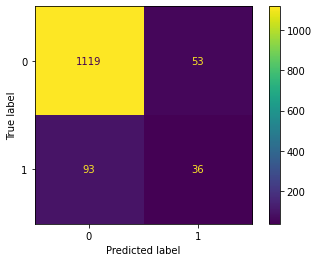

In [ ]:
cm = confusion_matrix(df_probas['True_label'],df_probas['predicted_label'])
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
print('Classification Report:')
print('\n')
print(classification_report(df_probas['True_label'],df_probas['predicted_label']))

In [ ]:
#tfidf?
#0.32